In [1]:
from pyFiDEL import SimClassifier, PCR, FiDEL

from pyFiDEL.ranks import (
    get_fermi_min,
    get_fermi_root,
    build_correspond_table,
    get_lambda,
    build_metric,
)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from wordcloud import WordCloud

import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')


#SKLEARN
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, accuracy_score, mean_absolute_error, mean_squared_error,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             homogeneity_score, completeness_score, v_measure_score,
                             adjusted_rand_score, rand_score, silhouette_score,
                             precision_recall_fscore_support)

from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation

# Prueba Clasificador con puntuación AUC como Objetivo

In [2]:
c = SimClassifier(N=10000, rho=0.5)
score = c.create_gaussian_scores(auc0=0.9, tol=1e-4)

INFO:simulator:Final AUC: 0.900071 (iter: 28) mu2: 1.812388


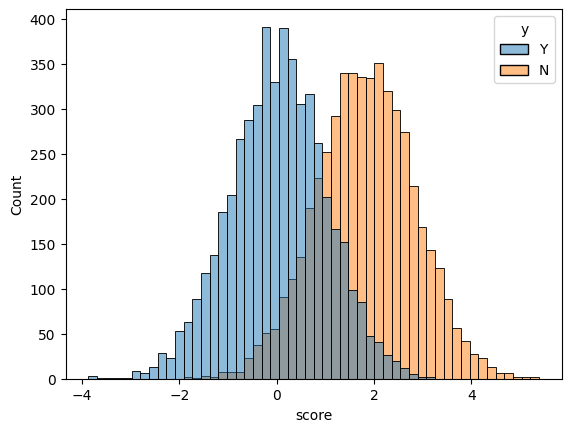

In [3]:
# show score histogram

c.plot_score()

#plt.savefig("score_dist.pdf", dpi=300)

In [7]:
# calculate metric and build curve information

df, info = build_metric(c.score, c.y)
df.head()

,score,y,rank,tpr,fpr,bac,prec
0,-4.124373,Y,1,0.0002,0.0,0.5001,1.0
1,-3.344915,Y,2,0.0004,0.0,0.5002,1.0
2,-3.216734,Y,3,0.0006,0.0,0.5003,1.0
3,-3.163014,Y,4,0.0008,0.0,0.5004,1.0
4,-3.105807,Y,5,0.0010,0.0,0.5005,1.0


Text(0, 0.5, 'True positive rate')

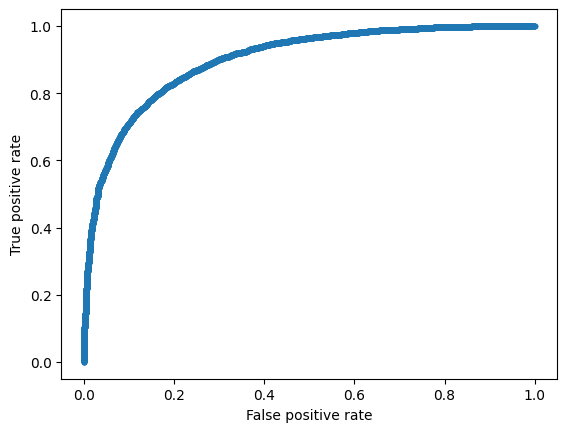

In [8]:
# Plot ROC curve

plt.plot(df["fpr"], df["tpr"], ".")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

#plt.savefig("roc_curve.pdf", dpi=300)

In [9]:
# minimum optimization method

auclist = [0.6, 0.7, 0.8, 0.9]
ans = pd.DataFrame()

for auc in auclist:
    ans = ans.append(get_fermi_min(auc, 0.5, resol=1e-5), ignore_index=True)

ans

C:\Users\57318\AppData\Local\Temp\ipykernel_2924\4257245348.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ans = ans.append(get_fermi_min(auc, 0.5, resol=1e-5), ignore_index=True)
C:\Users\57318\AppData\Local\Temp\ipykernel_2924\4257245348.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ans = ans.append(get_fermi_min(auc, 0.5, resol=1e-5), ignore_index=True)
C:\Users\57318\AppData\Local\Temp\ipykernel_2924\4257245348.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ans = ans.append(get_fermi_min(auc, 0.5, resol=1e-5), ignore_index=True)
C:\Users\57318\AppData\Local\Temp\ipykernel_2924\4257245348.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pa

,beta,mu,r_star
0,1.220736,0.499996,0.499996
1,2.595059,0.499997,0.499997
2,4.394915,0.499997,0.499997
3,7.560261,0.500003,0.500003


# Intento con Corpus Mensajes de Odio
Se utilizo la base de datos `df_odio` del taller anterior. Para extraerla se utilizo el siguiente codigo:

```
! pip install datasets transformers
from datasets import load_dataset
dataset_odio = load_dataset("hate_speech18", split ="train")

def dataset_to_dataframe(dataset):
    # Inicializar listas para cada feature
    text_list = []
    user_id_list = []
    subforum_id_list = []
    num_contexts_list = []
    label_list = []

    # Extraer valores de cada feature del dataset
    for data_val in dataset:
        text_list.append(data_val.get('text', None))
        user_id_list.append(data_val.get('user_id', None))
        subforum_id_list.append(data_val.get('subforum_id', None))
        num_contexts_list.append(data_val.get('num_contexts', None))
        label_list.append(data_val.get('label', None))

    # Crear DataFrame a partir de las listas de features
    df = pd.DataFrame({
        'text': text_list,
        'user_id': user_id_list,
        'subforum_id': subforum_id_list,
        'num_contexts': num_contexts_list,
        'label': label_list
    })

    return df
df_odio = dataset_to_dataframe(dataset_odio)
df_odio.to_csv("df_odio.csv", index=False)
```

In [3]:
df_odio = pd.read_csv("df_odio.csv")
df_odio.head()

,text,user_id,subforum_id,num_contexts,label
0,"As of March 13th , 2014 , the booklet had been...",572066,1346,0,0
1,In order to help increase the booklets downloa...,572066,1346,0,0
2,( Simply copy and paste the following text int...,572066,1346,0,0
3,Click below for a FREE download of a colorfull...,572066,1346,0,1
4,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,572066,1346,0,0


In [6]:
df_odio["label"].unique()

array([0, 1, 2, 3], dtype=int64)

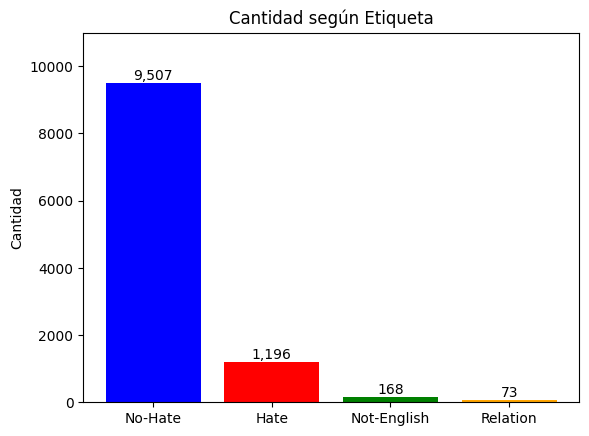

In [7]:
fig, ax = plt.subplots()
categories = ['No-Hate', 'Hate', 'Not-English', 'Relation']
bar_container = ax.bar(categories, df_odio['label'].value_counts(), color=['blue', 'red', 'green', 'orange'])
# ax.yaxis.set_visible(False)
ax.set(ylabel='Cantidad', title='Cantidad según Etiqueta', ylim=(0, 11000))
ax.bar_label(bar_container, fmt='{:,.0f}');

Debido a que los textos con etiqueta 2 están escritos en un idioma diferente al del sistema de clasificación, su inclusión genera ruido que afecta negativamente la precisión del proceso. Por tal motivo, se ha tomado la decisión de eliminar estos textos del corpus para optimizar el rendimiento del sistema

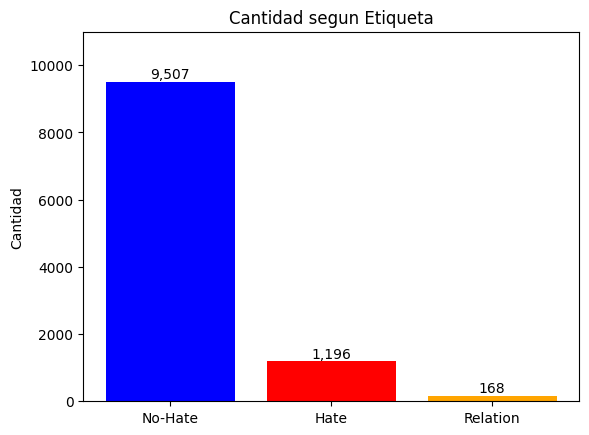

In [10]:
df_odio = df_odio.drop((df_odio[df_odio["label"] == 2]).index)
fig, ax = plt.subplots()
categories = ['No-Hate', 'Hate', 'Relation']
bar_container = ax.bar(categories, df_odio['label'].value_counts(), color=['blue', 'red', 'orange'])
ax.set(ylabel='Cantidad', title='Cantidad segun Etiqueta', ylim=(0, 11000))
ax.bar_label(bar_container, fmt='{:,.0f}');

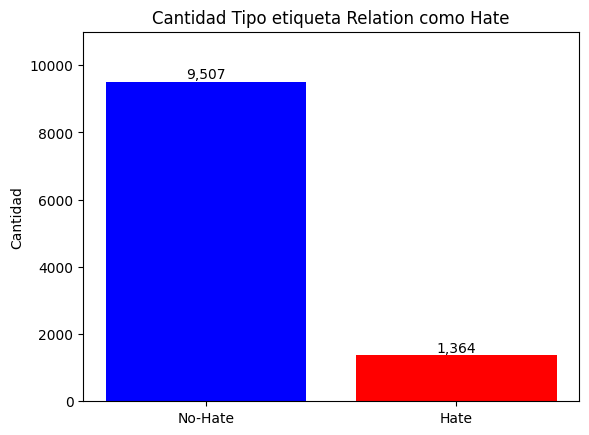

In [6]:
df_odio = pd.read_csv("df_odio.csv")
df_odio = df_odio.drop((df_odio[df_odio["label"] == 2]).index)
df_odio_relation = df_odio.copy(deep=True)
df_odio_relation['label'].replace(3, 1, inplace = True) #Le decimos al sistema que trate la etiqueta Relation como Hate
fig, ax = plt.subplots()
categories = ['No-Hate', 'Hate']
bar_container = ax.bar(categories, df_odio_relation['label'].value_counts(), color=['blue', 'red'])
# ax.yaxis.set_visible(False)
ax.set(ylabel='Cantidad', title='Cantidad Tipo etiqueta Relation como Hate', ylim=(0, 11000))
ax.bar_label(bar_container, fmt='{:,.0f}');

In [7]:
def remove_non_alphabetic(text):
    return ''.join([char for char in text if char.isalpha() or char.isspace() or emoji.is_emoji(char)])

# Algoritmo de preprocesamiento
def preprocess_text(df):

    stop_words = set(stopwords.words('english'))

    # Convertir los textos a minúsculas
    df["text"] = df["text"].str.lower()

    # Eliminar caracteres no alfabéticos, manteniendo emojis
    df["text"] = df["text"].apply(remove_non_alphabetic)

    # Eliminar stop-words
    df["text"] = df["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    return df

# Aplicar el preprocesamiento al DataFrame
#df = preprocess_text(df)

# Inicializar Stemmer y Lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Función para hacer stemming y lematización
def stem_and_lemmatize(text):
    tokens = nltk.word_tokenize(text)
    stemmed = [stemmer.stem(token) for token in tokens]
    lemmatized = [lemmatizer.lemmatize(token) for token in stemmed]
    return ' '.join(lemmatized)

In [8]:
# Aplicar el preprocesamiento al DataFrame
df_odio_relation = preprocess_text(df_odio_relation)
df_odio_relation['Lematizado_Stemming'] = df_odio_relation['text'].apply(stem_and_lemmatize)
print("Informacion Corpus")
print("Valores Null por columna:")
df_odio_relation.isnull().sum()

Informacion Corpus
Valores Null por columna:


text                   0
user_id                0
subforum_id            0
num_contexts           0
label                  0
Lematizado_Stemming    0
dtype: int64

In [13]:
df_odio_relation.head()

,text,user_id,subforum_id,num_contexts,label,Lematizado_Stemming
0,march th booklet downloaded times counting,572066,1346,0,0,march th booklet download time count
1,order help increase booklets downloads would g...,572066,1346,0,0,order help increas booklet download would grea...
2,simply copy paste following text youtube video...,572066,1346,0,0,simpli copi past follow text youtub video desc...
3,click free download colorfully illustrated pag...,572066,1346,0,1,click free download color illustr page ebook z...
4,click download mb green banner link,572066,1346,0,0,click download mb green banner link


## Vectorizacion Corpus

In [14]:
# TfidfVectorizer
vectorizer_TFIDF = TfidfVectorizer(max_df = 0.3,
                             min_df = 8,
                             stop_words = "english",
                             lowercase = True,
                             use_idf = True,
                             norm = "l2",
                             smooth_idf = True
                                   )
#Para corpus
text_norm_VecTFIDF = vectorizer_TFIDF.fit_transform(df_odio_relation["Lematizado_Stemming"])

In [50]:
text_norm_VecTFIDF

<10871x1692 sparse matrix of type '<class 'numpy.float64'>'
	with 58176 stored elements in Compressed Sparse Row format>

## LSA por 2 Dimensiones

In [51]:
# aplicar LSA para reducir la dimensionalidad (reducir a 2 dimensiones)
n_components = 2
lsa = TruncatedSVD(n_components = n_components)
lsa_matrix = lsa.fit_transform(text_norm_VecTFIDF)

# DataFrame para visualizar las componentes
lsa_df = pd.DataFrame(lsa_matrix,
                      columns = [f"Componente {i+1}" for i in range(n_components)])
lsa_df.insert(0, "Post", [f"Post {i+1}" for i in range(lsa_df.shape[0])])
lsa_df.insert(1, "text", df_odio_relation["text"])
print(f" LSA en {n_components} Componentes")
print(f" Tamaño LSA en {n_components} Componentes", lsa_df.shape)
lsa_df.head()

 LSA en 2 Componentes
 Tamaño LSA en 2 Componentes (10871, 4)


,Post,text,Componente 1,Componente 2
0,Post 1,march th booklet downloaded times counting,0.039836,0.015554
1,Post 2,order help increase booklets downloads would g...,0.069332,0.010783
2,Post 3,simply copy paste following text youtube video...,0.048707,0.005514
3,Post 4,click free download colorfully illustrated pag...,0.027256,0.003908
4,Post 5,click download mb green banner link,0.016924,0.012539


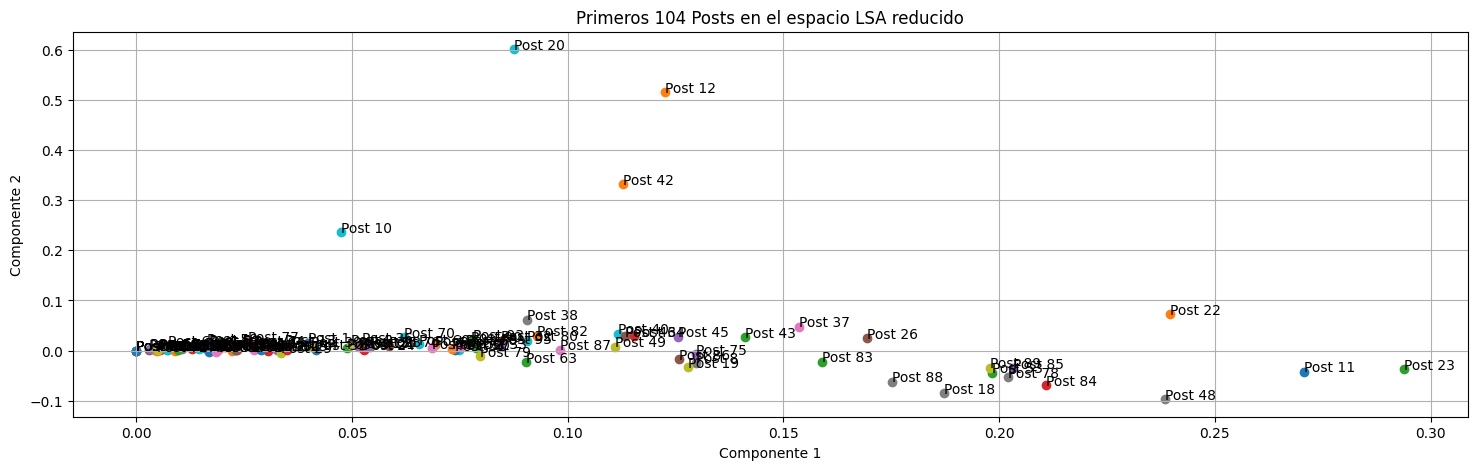

In [21]:
#graficar en 2D (solo voy a graficar 103 primeros v':)
n = range(int(np.floor(np.sqrt(len(lsa_df))))) #FULL range(len(lsa_df))
plt.figure(figsize=(18, 5))
for i in n:
    plt.scatter(lsa_df.loc[i, "Componente 1"], lsa_df.loc[i, "Componente 2"])
    plt.text(lsa_df.loc[i, "Componente 1"], lsa_df.loc[i, "Componente 2"], lsa_df.loc[i, "Post"])

plt.xlabel("Componente 1")
plt.grid(True, which = "both")
plt.ylabel("Componente 2")
plt.title(f"Primeros {np.shape(n)[0]} Posts en el espacio LSA reducido")
plt.show()

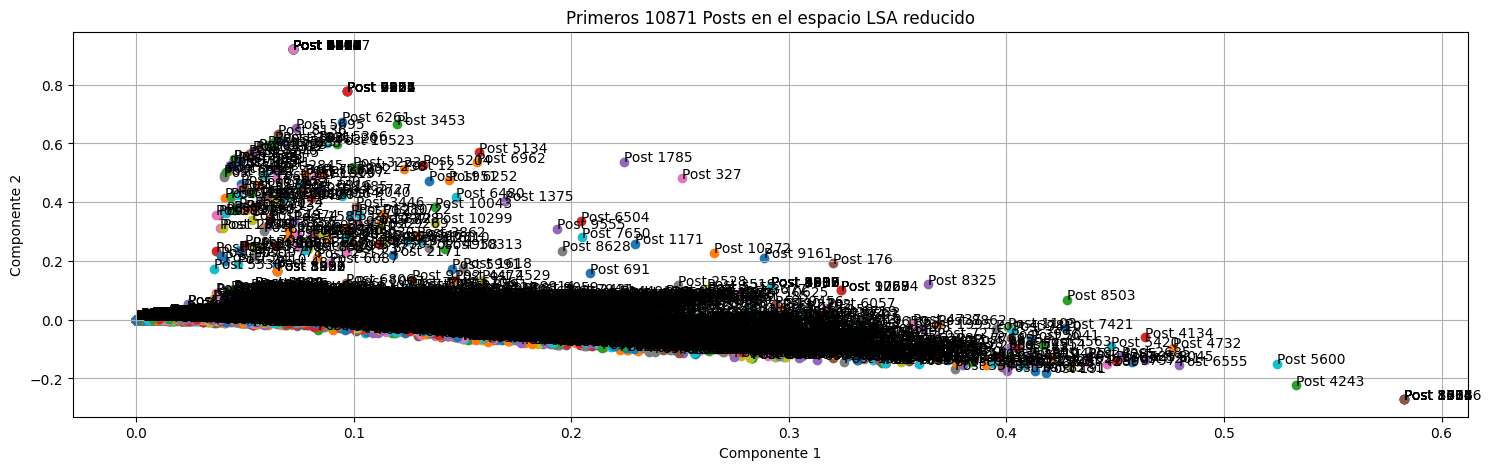

In [52]:
n = range(len(lsa_df)) #range(int(np.floor(np.sqrt(len(lsa_df))))) #FULL range(len(lsa_df))
plt.figure(figsize=(18, 5))
for i in n:
    plt.scatter(lsa_df.loc[i, "Componente 1"], lsa_df.loc[i, "Componente 2"])
    plt.text(lsa_df.loc[i, "Componente 1"], lsa_df.loc[i, "Componente 2"], lsa_df.loc[i, "Post"])

plt.xlabel("Componente 1")
plt.grid(True, which = "both")
plt.ylabel("Componente 2")
plt.title(f"Primeros {np.shape(n)[0]} Posts en el espacio LSA reducido")
plt.show()

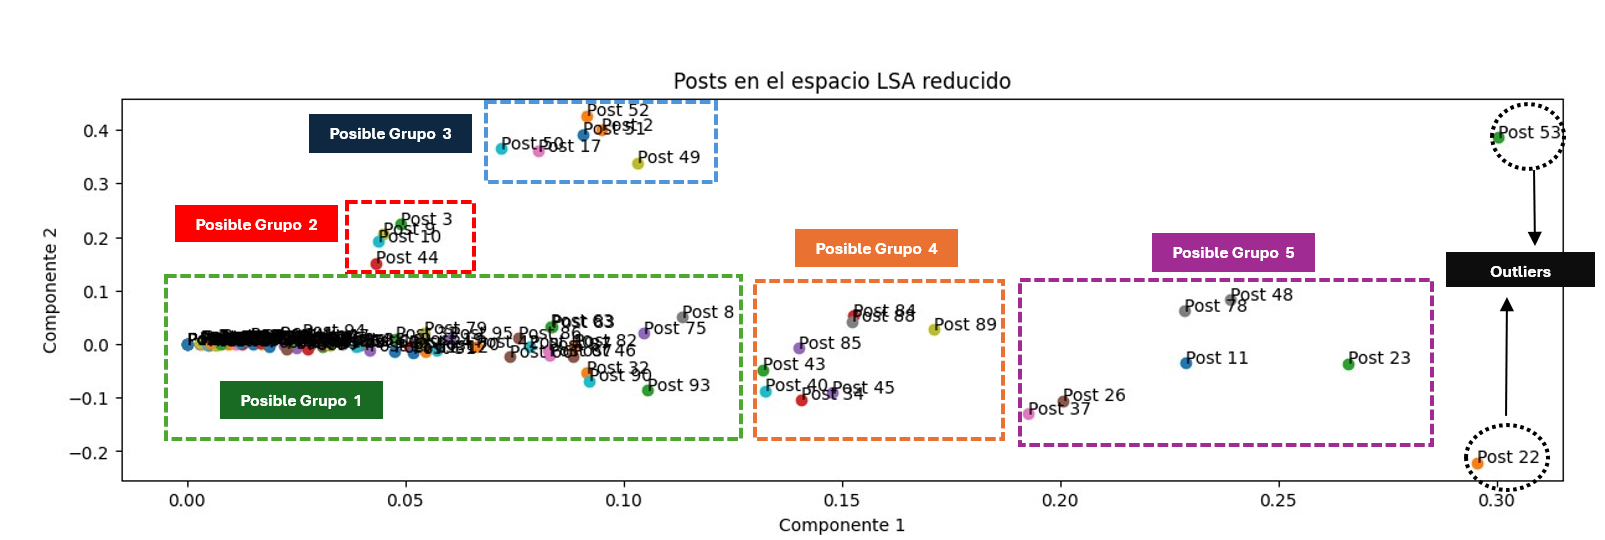

## LDA por Temáticas

In [15]:
n_topics = 2  # define el numero de tópicos que a extraer
lda = LatentDirichletAllocation(n_components = n_topics,
                                random_state = 123,
                                learning_method = 'batch',
                                learning_decay = 0.7,
                                learning_offset = 10.0,
                                max_iter = 10,
                                batch_size = 128,
                                evaluate_every = -1,
                                total_samples = 1000000.0,
                                perp_tol = 0.1,
                                mean_change_tol = 0.001)
lda.fit(text_norm_VecTFIDF)

LatentDirichletAllocation(n_components=2, random_state=123)

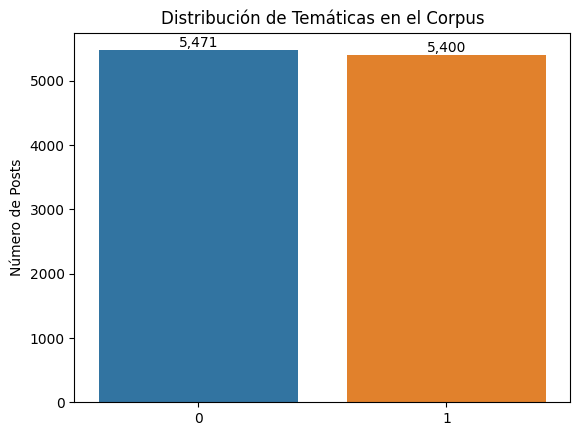

In [16]:
# Visualización de la distribución de tópicos
doc_topic_distribution = lda.transform(text_norm_VecTFIDF)
topic_distribution = doc_topic_distribution.sum(axis = 0)

ax = sns.barplot(x = np.arange(n_topics), y = topic_distribution)
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:,.0f}')
ax.set(ylabel="Número de Posts", title = "Distribución de Temáticas en el Corpus");

In [42]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Tópico %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer_CVec.get_feature_names_out(), no_top_words)

Tópico 0:
aufidena carey carri chill bath antelop bonu chicken blur beaver
Tópico 1:
charlton blacksasian agu beaver carlo beforepl bt blur birthcertif br


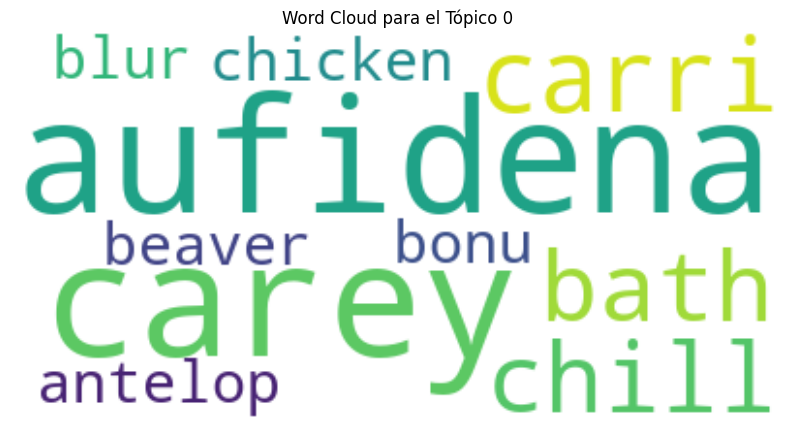

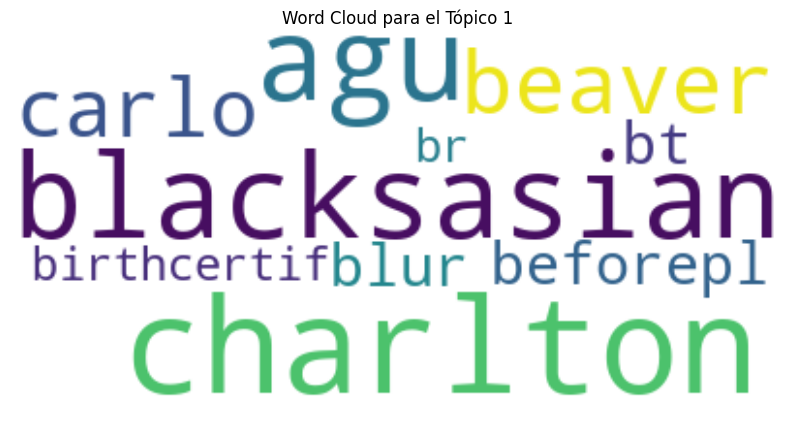

In [43]:
#CountVectorizer
vectorizer_CVec = CountVectorizer(strip_accents = "ascii",
                                  lowercase = True,
                                  stop_words = "english",
                                  max_df = 0.3)

# Convertir los textos en una matriz TF-IDF
text_norm_vectorizer_CVec = vectorizer_CVec.fit_transform(df_odio_relation["Lematizado_Stemming"]) # vectorizer_CVec.fit_transform(), vectorizer_Hashing

for topic_idx, topic in enumerate(lda.components_):
    plt.figure(figsize=(10, 6))
    wordcloud = WordCloud(background_color='white').generate(" ".join([vectorizer_CVec.get_feature_names_out()[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud para el Tópico {topic_idx}')
    plt.show()

## Supervised learning

In [17]:
X = text_norm_VecTFIDF #text_norm_CountVec, text_norm_HashingVec
t = df_odio_relation["label"]
tam_test = 0.3
X_train, X_test , y_train, y_test = train_test_split(X, t, test_size = tam_test, random_state = 123, stratify = t, shuffle = True)
print("Tamaño Caracteristicas de Entrenamiento: ",X_train.shape)
print("Tamaño Caracteristicas de Prueba: ",X_test.shape)
print("Tamaño Etiquetas de Entrenamiento: ",y_train.shape)
print("Tamaño Etiquetas de Prueba: ",y_test.shape)

Tamaño Caracteristicas de Entrenamiento:  (7609, 1692)
Tamaño Caracteristicas de Prueba:  (3262, 1692)
Tamaño Etiquetas de Entrenamiento:  (7609,)
Tamaño Etiquetas de Prueba:  (3262,)


In [29]:
def evaluate_model(y_test, y_pred, model, labels, display_labels):
    print("Evaluación del Modelo \n")
    
    print(".-"*50)
    correct_labels = sum(y_test == y_pred)
    print("Se etiquetaron correctamente %d de un total de %d muestras." % (correct_labels, y_test.size))
    print(".-"*50)
    # AUC
    print("Area Bajo la Curva (AUC):", np.round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]), 3))
    print(".-"*50)
    
    # Calcular MAE y RMSE
    print(f" Error MAE: {np.round(mean_absolute_error(y_test, y_pred), 3)}")
    print(f" Error RMSE: {np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 3)}")
    print(".-"*50)

    # Imprimir el reporte de clasificación
    print("Reporte de clasificación")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(".-"*50)

    # Mostrar la matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels).plot()
    plt.title("Matriz de confusion")
    plt.show()

### Logistic Regression

Evaluación del Modelo 

.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Se etiquetaron correctamente 2912 de un total de 3262 muestras.
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Area Bajo la Curva (AUC): 0.828
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
 Error MAE: 0.107
 Error RMSE: 0.328
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Reporte de clasificación
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2853
           1       0.66      0.30      0.41       409

    accuracy                           0.89      3262
   macro avg       0.78      0.64      0.67      3262
weighted avg       0.88      0.89      0.87      3262

.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

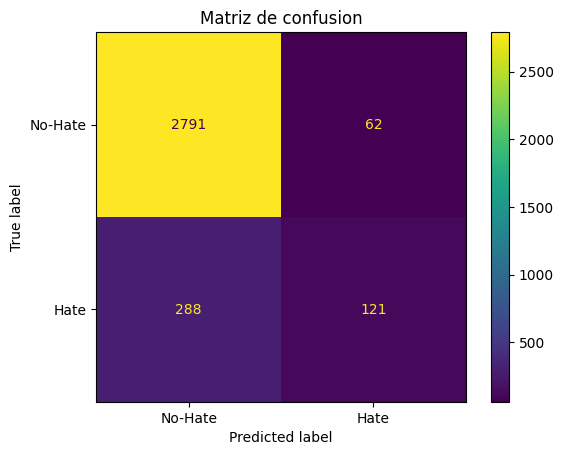

In [30]:
model_LogisticRegression = LogisticRegression(C = 5, solver = "liblinear", max_iter = 10000, random_state = 123)
model_LogisticRegression.fit(X_train, y_train)
y_pred_LogisticRegression = model_LogisticRegression.predict(X_test)
evaluate_model(y_test, y_pred_LogisticRegression, model = model_LogisticRegression,  labels=np.unique(df_odio_relation["label"]), display_labels=["No-Hate", "Hate"])

### K-nearest neighbor classifier

Evaluación del Modelo 

.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Se etiquetaron correctamente 2851 de un total de 3262 muestras.
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Area Bajo la Curva (AUC): 0.558
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
 Error MAE: 0.126
 Error RMSE: 0.355
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Reporte de clasificación
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      2853
           1       0.38      0.01      0.01       409

    accuracy                           0.87      3262
   macro avg       0.63      0.50      0.47      3262
weighted avg       0.81      0.87      0.82      3262

.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

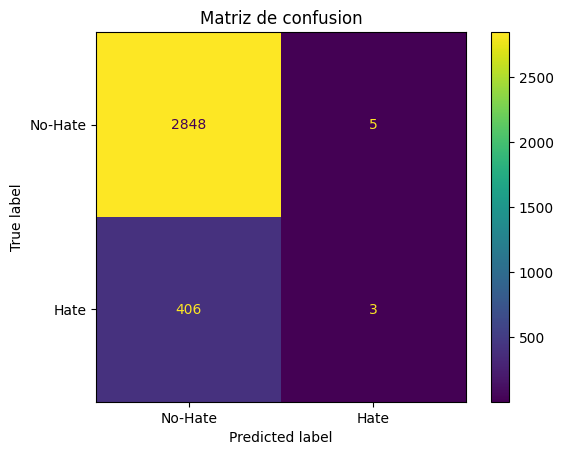

In [31]:
model_KNeighbors = KNeighborsClassifier(n_neighbors = 5)
model_KNeighbors.fit(X_train, y_train)
y_pred_KNeighbors = model_KNeighbors.predict(X_test)
evaluate_model(y_test, y_pred_KNeighbors,  model = model_KNeighbors, labels=np.unique(df_odio_relation["label"]), display_labels=["No-Hate", "Hate"])

### AdaBoost Classifier

Evaluación del Modelo 

.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Se etiquetaron correctamente 2859 de un total de 3262 muestras.
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Area Bajo la Curva (AUC): 0.698
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
 Error MAE: 0.124
 Error RMSE: 0.351
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Reporte de clasificación
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2853
           1       0.55      0.08      0.14       409

    accuracy                           0.88      3262
   macro avg       0.72      0.54      0.54      3262
weighted avg       0.84      0.88      0.83      3262

.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

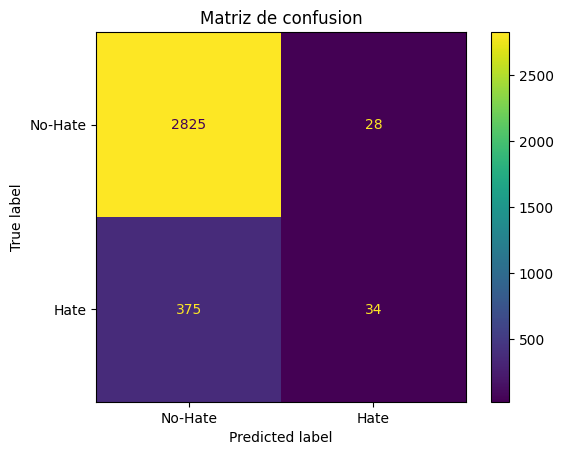

In [33]:
model_ADA = AdaBoostClassifier(algorithm = "SAMME", random_state = 123) #(priors = np.unique(df_odio_relation["label"]))
model_ADA.fit(X_train, y_train)
y_pred_ADA = model_ADA.predict(X_test)
evaluate_model(y_test, y_pred_ADA, model = model_ADA,  labels=np.unique(df_odio_relation["label"]), display_labels=["No-Hate", "Hate"])

### Random Forest Classifier

Evaluación del Modelo 

.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Se etiquetaron correctamente 2865 de un total de 3262 muestras.
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Area Bajo la Curva (AUC): 0.802
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
 Error MAE: 0.122
 Error RMSE: 0.349
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Reporte de clasificación
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2853
           1       0.55      0.17      0.26       409

    accuracy                           0.88      3262
   macro avg       0.72      0.58      0.60      3262
weighted avg       0.85      0.88      0.85      3262

.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

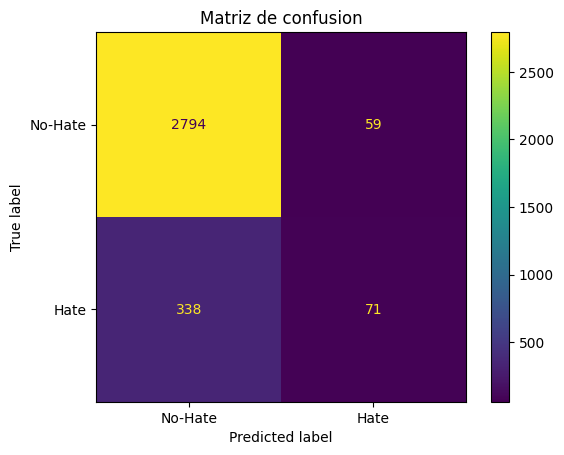

In [35]:
model_rdomForest = RandomForestClassifier(class_weight = "balanced", random_state = 123)
model_rdomForest.fit(X_train, y_train)
y_pred_rdomForest = model_rdomForest.predict(X_test)
evaluate_model(y_test, y_pred_rdomForest, model = model_rdomForest,  labels=np.unique(df_odio_relation["label"]), display_labels=["No-Hate", "Hate"])

### Gaussian Naive Bayes

In [36]:
model_GaussianNB = GaussianNB() #(priors = np.unique(df_odio_relation["label"]))
model_GaussianNB.fit(X_train.toarray(), y_train)
y_pred_GaussianNB = model_GaussianNB.predict(X_test.toarray())
# AUC
print("Area Bajo la Curva")
print("AUC: ", np.round(roc_auc_score(y_test, model_GaussianNB.predict_proba(X_test.toarray())[:,1]), 3))
print("*-"*50)

evaluate_model(y_test, y_pred_GaussianNB, model = model_GaussianNB,  labels=np.unique(df_odio_relation["label"]), display_labels=["No-Hate", "Hate"])

Area Bajo la Curva
AUC:  0.572
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Evaluación del Modelo 

.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Se etiquetaron correctamente 1370 de un total de 3262 muestras.
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-


TypeError: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

### Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores from all models

In [32]:
# Función principal que entrena y evalúa los modelo
def AUCS_models(df, X, labels, tam_test):
    t = df["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, t, test_size=tam_test, random_state=123, stratify=t, shuffle=True)

    # Definición de modelos
    models = {
        "Logistic Regression": LogisticRegression(C = 5, solver = "liblinear", max_iter = 10000, random_state = 123),
        "Ridge Regression": RidgeClassifier(tol=1e-2, solver="sparse_cg", random_state = 123),
        "Decision Tree": DecisionTreeClassifier(random_state = 123),
        "Linear SVC": LinearSVC(C=0.1, dual=False, max_iter=1000, random_state = 123),
        "K-nearest Neighbor": KNeighborsClassifier(n_neighbors = 5),
        "AdaBoost": AdaBoostClassifier(algorithm = "SAMME", random_state = 123),
        "Random Forest": RandomForestClassifier(class_weight = "balanced", random_state = 123),
        "Gaussian Naive Bayes": GaussianNB()


    }

    #CALCULAMOS AUC
    results = []

    for name, model in models.items():
        if isinstance(model, GaussianNB):
            X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
            X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test
            model.fit(X_train_dense, y_train)
            y_scores = model.predict_proba(X_test_dense)[:, 1]
        else:
            model.fit(X_train, y_train)
            if hasattr(model, "decision_function"):
                y_scores = model.decision_function(X_test)
            else:
                y_scores = model.predict_proba(X_test)[:, 1]
        auc = np.round(roc_auc_score(y_test, y_scores), 3)
        results.append((name, auc))

    # Crear un DataFrame con los resultados
    results_df = pd.DataFrame(results, columns=["Model", "AUC"])
    return results_df

In [33]:
categories = ["No-Hate", "Hate"]
AUC_df = AUCS_models(df = df_odio_relation, 
                                   X = text_norm_VecTFIDF , 
                                   labels = categories, 
                                   tam_test = 0.3)
AUC_df

,Model,AUC
0,Logistic Regression,0.828
1,Ridge Regression,0.828
2,Decision Tree,0.614
3,Linear SVC,0.843
4,K-nearest Neighbor,0.555
5,AdaBoost,0.698
6,Random Forest,0.802
7,Gaussian Naive Bayes,0.572


## Clasificador no supervisado

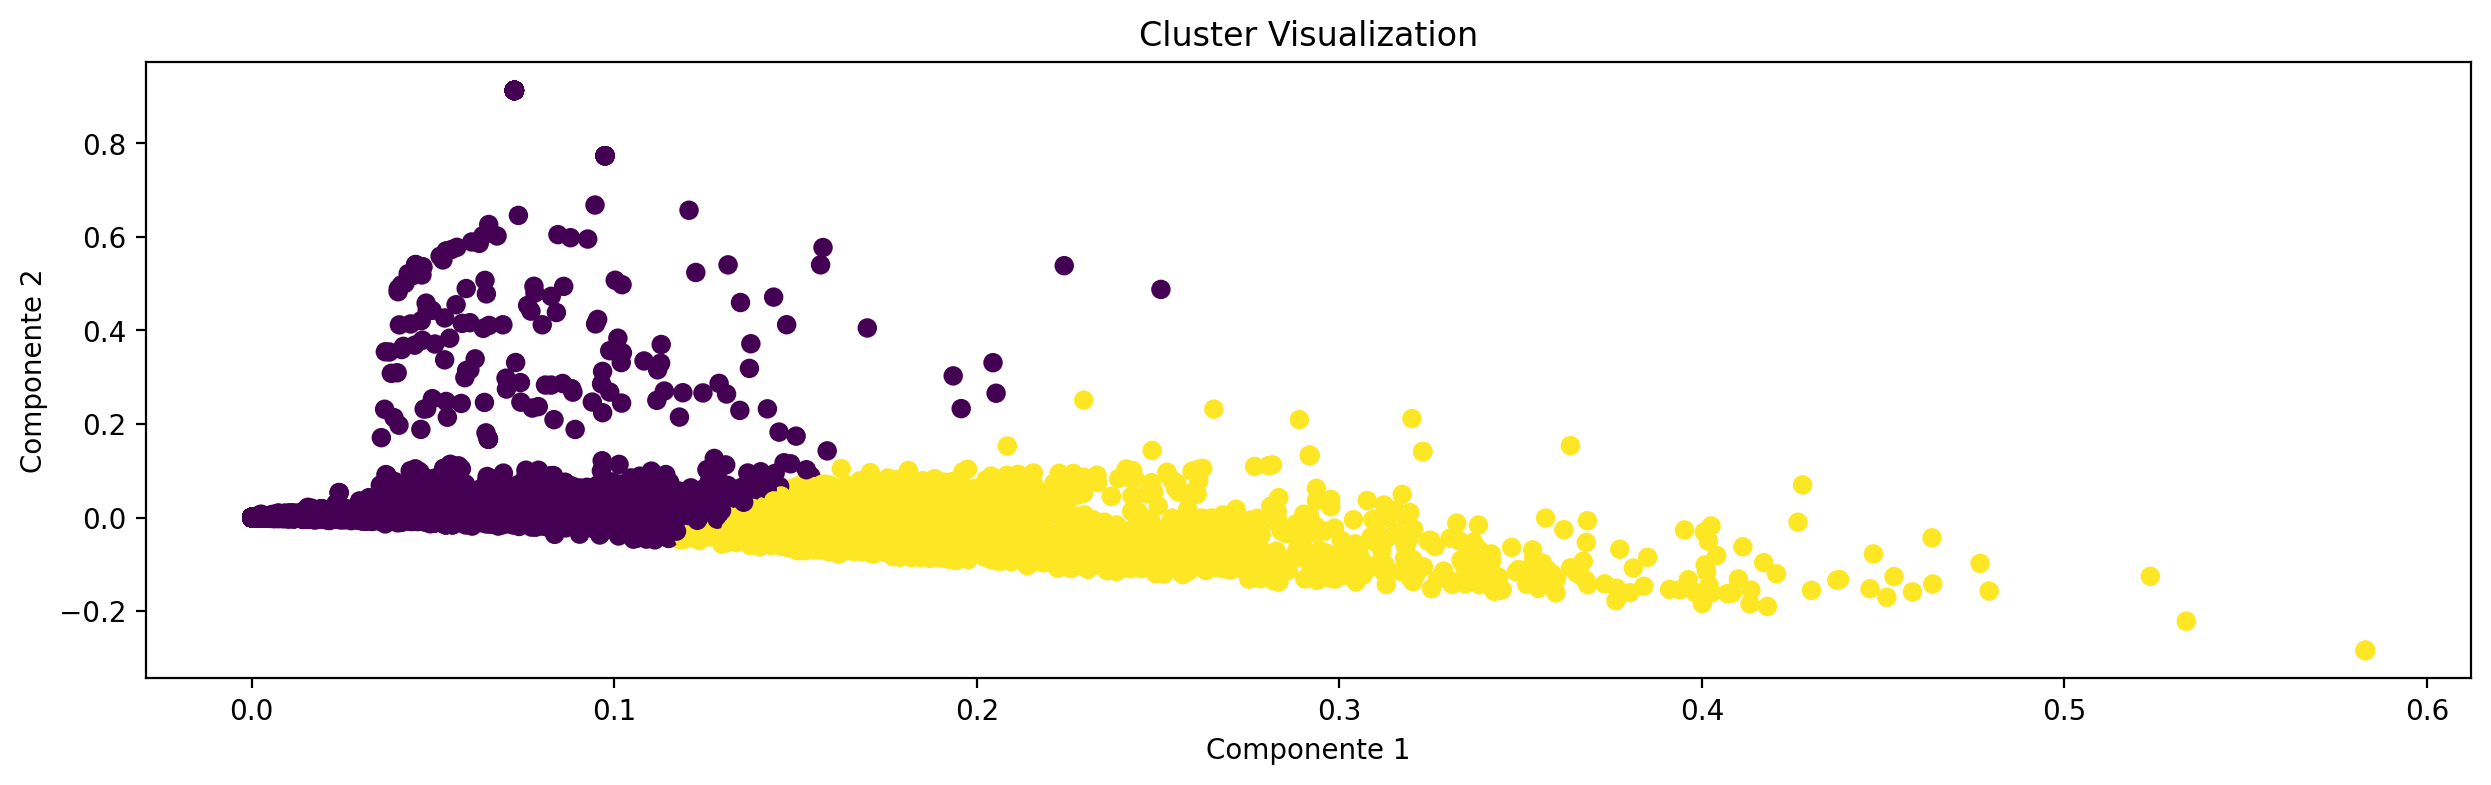

In [43]:
#REPRESENTACION EN ESPACIO VECTORIAL
vectorizer_TFIDF = TfidfVectorizer(max_df=0.3,
                             min_df=8,
                             stop_words="english",
                             lowercase=True,
                             use_idf=True,
                             norm="l2",
                             smooth_idf=True
                                   )
#Para corpus
text_norm_VecTFIDF = vectorizer_TFIDF.fit_transform(df_odio_relation["Lematizado_Stemming"])

#LSA
lsa = TruncatedSVD(n_components = 2 )
lsa_matrix = lsa.fit_transform(text_norm_VecTFIDF)

# Guardamos las componentes en un dataframe de componentes
X = pd.DataFrame(lsa_matrix,
                      columns = [f"Componente {i+1}" for i in range(n_components)])

#Num de clusters
num_clusters = df_odio_relation["label"].unique().shape[0] #numero real de clusters
#num_clusters = 5 #numero de heh


# KMEANS
kmeans = KMeans(n_clusters = num_clusters,
                init = "k-means++",
                n_init = "auto",
                random_state = 42)
y_kmeans = kmeans.fit(X)#Ajustamos


# Visualization
plt.figure(figsize = (15,4), dpi = 200)
plt.scatter(X.iloc[:, 0],
            X.iloc[:, 1],
            c = y_kmeans.fit_predict(X),
            cmap ='viridis')
plt.title('Cluster Visualization')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

In [44]:
y = df_odio_relation["label"]
y_KM_labels = kmeans.labels_
correct_labels = sum(y == y_KM_labels)
y_kmeans = kmeans.fit_predict(X)

#metricas
MAE = np.round(mean_absolute_error(y, y_kmeans), 3) #Error medio absoluto
RMSE = np.round(np.sqrt(mean_squared_error(y, y_kmeans)), 3) #Error cuadrático medio
homogeneity = np.round(homogeneity_score(y, y_kmeans), 3) #Homogeneidad
completeness = np.round(completeness_score(y, y_kmeans), 3) #Completeness Score
v_measure =  np.round(v_measure_score(y, y_kmeans), 3) #V measure Score
adjusted_rand =  np.round(adjusted_rand_score(y, y_kmeans), 3) #Adjusted Rand-Index
silhouette =  np.round(silhouette_score(X, y_kmeans), 3) #Silhouette Coefficien

# Imprimir
print("Métricas para Clasificacion \n")
print("Se etiquetaron correctamente %d de un total de %d muestras." % (correct_labels, y.size))
print("- Accuracy: {0:0.2f}". format(correct_labels/float(y.size)))
print(f"- MAE: {MAE}")
print(f"- RMSE: {RMSE}")
print(f"- Homogeneidad: {homogeneity}")
print(f"- Completitud: {completeness}")
print(f"- Indice V: {v_measure}")
print(f"- Información Mutua Ajustada: {adjusted_rand}")
print(f"- Silhouette: {silhouette}")

Métricas para Clasificacion 

Se etiquetaron correctamente 8453 de un total de 10871 muestras.
- Accuracy: 0.78
- MAE: 0.222
- RMSE: 0.472
- Homogeneidad: 0.018
- Completitud: 0.015
- Indice V: 0.016
- Información Mutua Ajustada: 0.086
- Silhouette: 0.597


## FiDEL

In [36]:
AUC_df["AUC"]

0    0.828
1    0.828
2    0.614
3    0.843
4    0.555
5    0.698
6    0.802
7    0.572
Name: AUC, dtype: float64

In [44]:
# prepare classifier results

n_samples = 10000
c = SimClassifier(N=n_samples, rho=0.7)
#auc_list = [0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66]
auc_list = AUC_df["AUC"]

# create predictions
prediction = c.create_predictions(n_methods=20, auc_list=auc_list)

INFO:simulator:Final AUC: 0.549976 (iter: 185) mu2: 0.177712
INFO:simulator:Final AUC: 0.559963 (iter: 35) mu2: 0.213503
INFO:simulator:Final AUC: 0.569910 (iter: 42) mu2: 0.249431
INFO:simulator:Final AUC: 0.580019 (iter: 18) mu2: 0.285520
INFO:simulator:Final AUC: 0.589980 (iter: 25) mu2: 0.321797
INFO:simulator:Final AUC: 0.600018 (iter: 8) mu2: 0.358287
INFO:simulator:Final AUC: 0.610053 (iter: 140) mu2: 0.395017
INFO:simulator:Final AUC: 0.619945 (iter: 6) mu2: 0.432015
INFO:simulator:Final AUC: 0.629999 (iter: 48) mu2: 0.469312
INFO:simulator:Final AUC: 0.640069 (iter: 25) mu2: 0.506937
INFO:simulator:Final AUC: 0.650008 (iter: 43) mu2: 0.544925
INFO:simulator:Final AUC: 0.660072 (iter: 62) mu2: 0.583311


In [41]:
from pyFiDEL import SimClassifier, PCR, FiDEL


# prepare classifier results

n_samples = 1000
c = SimClassifier(N=n_samples, rho=0.7)

auc_list = AUC_df["AUC"]

# create predictions
prediction = c.create_predictions(n_methods=20, auc_list=auc_list)

f = FiDEL()
f.add_predictions(c.pred)
f.add_label(c.y)
f.calculate_performance(alpha = 0.5, method = "WoC")

INFO:simulator:Final AUC: 0.827981 (iter: 301) mu2: 1.338258
INFO:simulator:Final AUC: 0.827910 (iter: 281) mu2: 1.338258
INFO:simulator:Final AUC: 0.614095 (iter: 97) mu2: 0.409782
INFO:simulator:Final AUC: 0.842933 (iter: 25) mu2: 1.423921
INFO:simulator:Final AUC: 0.555029 (iter: 371) mu2: 0.195592
INFO:simulator:Final AUC: 0.697919 (iter: 31) mu2: 0.733492
INFO:simulator:Final AUC: 0.802067 (iter: 299) mu2: 1.200366
INFO:simulator:Final AUC: 0.572014 (iter: 32) mu2: 0.256635
INFO:ensemble:... sample #: 1000, method #: 8
INFO:ensemble:... estimated auc (ensemble): 0.548643


In [ ]:
model_list <- c('rmda', 'rotationForest', 'pls', 'rda', 'svmLinear', 'svmRadial', 'knn', 'earth', 
          'mlp', 'rf', 'gbm', 'ctree', 'C5.0', 'bayesglm', 'glm', 'glmnet', 'simpls', 'dwdRadial', 'xgbTree', 
          'xgbLinear', 'nnet')
t1 <- mtrainer(model_list, dataInfo = 'westnile')
t1 <- train.mtrainer(t1, y~., traininglist, update=T)

# CORPUS SPAM

In [53]:
df_spam = pd.read_csv("df_spam.csv")
df_spam.head()

,text,label,Lematizado_Stemming
0,ounce feather bowl hummingbird opec moment ala...,1,ounc feather bowl hummingbird opec moment alab...
1,wulvob get medircations online qnb ikud viagra...,1,wulvob get medirc onlin qnb ikud viagra escape...
2,computer connection cnn com wednesday escapenu...,0,comput connect cnn com wednesday escapenumb ma...
3,university degree obtain prosperous future mon...,1,univers degre obtain prosper futur money earn ...
4,thanks answers guys know checked rsync manual ...,0,thank answer guy know check rsync manual would...


In [55]:
# TfidfVectorizer
vectorizer_TFIDF = TfidfVectorizer(max_df=0.3,
                             min_df=8,
                             stop_words="english",
                             lowercase=True,
                             use_idf=True,
                             norm="l2",
                             smooth_idf=True
                                   )
#Para corpus
text_norm_VecTFIDF = vectorizer_TFIDF.fit_transform(df_spam["Lematizado_Stemming"])

In [56]:
# aplicar LSA para reducir la dimensionalidad (reducir a 2 dimensiones)
n_components = 2
lsa = TruncatedSVD(n_components = n_components)
lsa_matrix = lsa.fit_transform(text_norm_VecTFIDF)

In [57]:
# DataFrame para visualizar las componentes
lsa_df = pd.DataFrame(lsa_matrix,
                      columns = [f"Componente {i+1}" for i in range(n_components)])
lsa_df.insert(0, "Post", [f"Post {i+1}" for i in range(lsa_df.shape[0])])
lsa_df.insert(1, "text", df_spam["text"])
print(f" LSA en {n_components} Componentes")
print(f" Tamaño LSA en {n_components} Componentes", lsa_df.shape)
lsa_df.head()

 LSA en 2 Componentes
 Tamaño LSA en 2 Componentes (83448, 4)


,Post,text,Componente 1,Componente 2
0,Post 1,ounce feather bowl hummingbird opec moment ala...,0.002707,-0.000370
1,Post 2,wulvob get medircations online qnb ikud viagra...,0.058265,-0.004592
2,Post 3,computer connection cnn com wednesday escapenu...,0.212582,0.039873
3,Post 4,university degree obtain prosperous future mon...,0.087810,-0.006674
4,Post 5,thanks answers guys know checked rsync manual ...,0.112888,0.066799


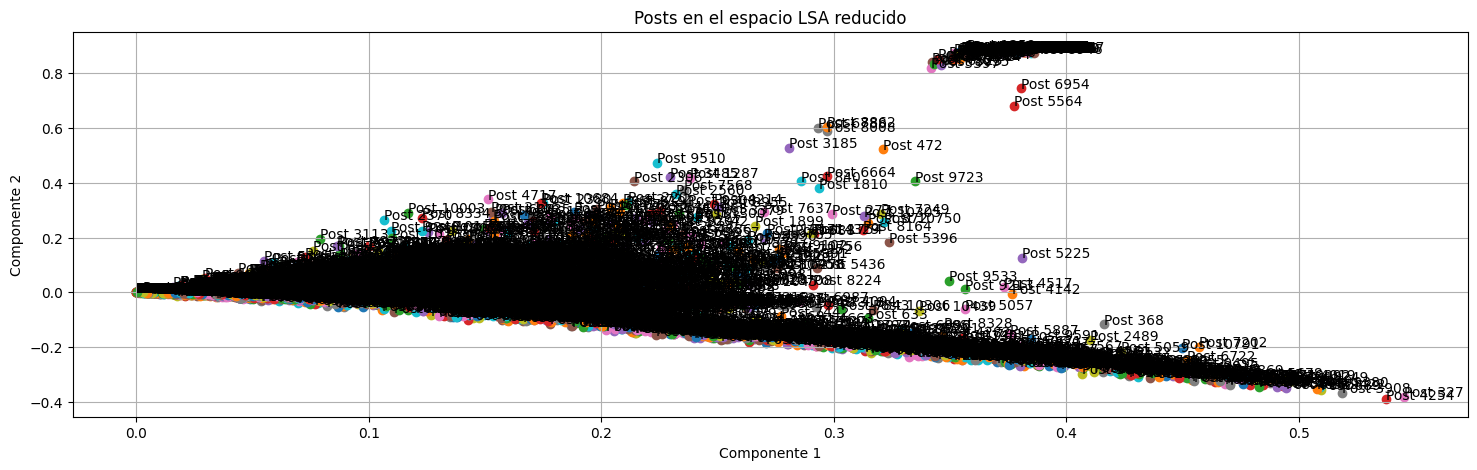

In [58]:
plt.figure(figsize=(18, 5))
for i in n:
    plt.scatter(lsa_df.loc[i, "Componente 1"], lsa_df.loc[i, "Componente 2"])
    plt.text(lsa_df.loc[i, "Componente 1"], lsa_df.loc[i, "Componente 2"], lsa_df.loc[i, "Post"])

plt.xlabel("Componente 1")
plt.grid(True, which = "both")
plt.ylabel("Componente 2")
plt.title("Posts en el espacio LSA reducido")
plt.show()